In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot

### 1. Define the V1Circuit model

In [2]:
lb = -5.
ub = 0.

sW = Parameter("sW", 1, lb=lb, ub=ub)
vW = Parameter("vW", 1, lb=lb, ub=ub)
dW = Parameter("dW", 1, lb=lb, ub=ub)
hW = Parameter("hW", 1, lb=lb, ub=ub)

parameters = [sW, vW, dW, hW]

model = Model("SC_Circuit", parameters)

In [3]:
import tensorflow as tf
DTYPE = tf.float32

t_cue_delay = 1.2
t_choice = 0.3
t_post_choice = 0.3
t_total = t_cue_delay + t_choice + t_post_choice
dt = 0.024
t = np.arange(0.0, t_total, dt)
T = t.shape[0]

fac = 0.5
# input parameters
E_constant = fac*1.5
E_Pbias = fac*1.
E_Prule = fac*1.2
E_Arule = fac*1.2
E_choice = fac*0.5
E_light = fac*1.
        
# set constant parameters
C = 2

theta = 0.05
beta = 0.5
tau = 0.09
sigma = 0.2

# inputs
I_constant = E_constant * tf.ones((T, 1, 1, 4, 1), dtype=DTYPE)

I_Pbias = np.zeros((T, 4))
I_Pbias[t < T * dt] = np.array([1, 0, 0, 1])
I_Pbias = I_Pbias[:,None,None,:,None]
I_Pbias = E_Pbias * tf.constant(I_Pbias, dtype=DTYPE)

I_Prule = np.zeros((T, 4))
I_Prule[t < 1.2] = np.array([1, 0, 0, 1])
I_Prule = I_Prule[:,None,None,:,None]
I_Prule = E_Prule * tf.constant(I_Prule, dtype=DTYPE)

I_Arule = np.zeros((T, 4))
I_Arule[t < 1.2] = np.array([0, 1, 1, 0])
I_Arule = I_Arule[:,None,None,:,None]
I_Arule = E_Arule * tf.constant(I_Arule, dtype=DTYPE)

I_choice = np.zeros((T, 4))
I_choice[t > 1.2] = np.array([1, 1, 1, 1])
I_choice = I_choice[:,None,None,:,None]
I_choice = E_choice * tf.constant(I_choice, dtype=DTYPE)

I_lightL = np.zeros((T, 4))
I_lightL[np.logical_and(1.2 < t, t < 1.5)] = np.array([1, 1, 0, 0])
I_lightL = I_lightL[:,None,None,:,None]
I_lightL = E_light * tf.constant(I_lightL, dtype=DTYPE)

I_lightR = np.zeros((T, 4))
I_lightR[np.logical_and(1.2 < t, t < 1.5)] = np.array([0, 0, 1, 1])
I_lightR = I_lightR[:,None,None,:,None]
I_lightR = E_light * tf.constant(I_lightR, dtype=DTYPE)

I_LP = I_constant + I_Pbias + I_Prule + I_choice + I_lightL
I_LA = I_constant + I_Pbias + I_Arule + I_choice + I_lightL

I = tf.concat((I_LP, I_LA), axis=2)


def SC_sim(sW, vW, dW, hW):
    N = 50
    Wrow1 = tf.stack([sW, vW, dW, hW], axis=2)
    Wrow2 = tf.stack([vW, sW, hW, dW], axis=2)
    Wrow3 = tf.stack([dW, hW, sW, vW], axis=2)
    Wrow4 = tf.stack([hW, dW, vW, sW], axis=2)
    
    W = tf.stack([Wrow1, Wrow2, Wrow3, Wrow4], axis=2)
    
    # initial conditions
    # M,C,4,1
    state_shape = (sW.shape[0], C, 4, N)
    v0 = 0.1 * tf.ones(state_shape, dtype=DTYPE)
    v0 = v0 + 0.005*tf.random.normal(v0.shape, 0., 1.)
    u0 = beta * tf.math.atanh(2 * v0 - 1) - theta

    v = v0
    u = u0
    v_t_list = [v]
    u_t_list = [u]
    for i in range(1, T):
        du = (dt / tau) * (-u + tf.matmul(W, v) + I[i] + sigma * tf.random.normal(state_shape, 0., 1.))
        #du = (dt / tau) * (-u + tf.matmul(W, v) + I[i] + sigma * w[i])
        u = u + du
        v = 1. * (0.5 * tf.tanh((u - theta) / beta) + 0.5)
        #v = eta[i] * (0.5 * tf.tanh((u - theta) / beta) + 0.5)
        v_t_list.append(v)
        u_t_list.append(u)

    u_t = tf.stack(u_t_list, axis=0)
    v_t = tf.stack(v_t_list, axis=0)
    return u_t, v_t

def SC_sim_wrap(z):
    sW = z[:,0][:,None]
    vW = z[:,1][:,None]
    dW = z[:,2][:,None]
    hW = z[:,3][:,None]
    return SC_sim(sW, vW, dW, hW)
    

def SC_acc(sW, vW, dW, hW):
    N = 200
    Wrow1 = tf.stack([sW, vW, dW, hW], axis=2)
    Wrow2 = tf.stack([vW, sW, hW, dW], axis=2)
    Wrow3 = tf.stack([dW, hW, sW, vW], axis=2)
    Wrow4 = tf.stack([hW, dW, vW, sW], axis=2)
    
    W = tf.stack([Wrow1, Wrow2, Wrow3, Wrow4], axis=2)
    
    # initial conditions
    # M,C,4,N
    state_shape = (sW.shape[0], C, 4, N)
    v0 = 0.1 * tf.ones(state_shape, dtype=DTYPE)
    v0 = v0 + 0.005*tf.random.normal(v0.shape, 0., 1.)
    u0 = beta * tf.math.atanh(2 * v0 - 1) - theta

    v = v0
    u = u0
    for i in range(1, T):
        du = (dt / tau) * (-u + tf.matmul(W, v) + I[i] + sigma * tf.random.normal(state_shape, 0., 1.))
        u = u + du
        v = 1. * (0.5 * tf.tanh((u - theta) / beta) + 0.5)
        #v = eta[i] * (0.5 * tf.tanh((u - theta) / beta) + 0.5)

    p = tf.reduce_mean(tf.math.sigmoid(100.*(v[:,:,0,:]-v[:,:,3,:])), axis=2)
    return p

In [4]:
model.set_eps(SC_acc)
mu_std = 0.1

epi_df = model.get_epi_df()
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['p'] = [ep['mu'][0] for ep in epi_df['EP']]
epi_df['mu_len'] = [ep['mu'].shape[0] for ep in epi_df['EP']]

data/epi/SC_Circuit/9ec2a8a430e51c2043a7e4151f221de1/D4_C3_L2_U50_bnmom=9.90E-01_PA_rs1/f1c76a7af74bf78f96682bd2fc852d21/N100_lr1.00E-03_c0=1.00E+03_gamma2.50E-01_beta4.00E+00


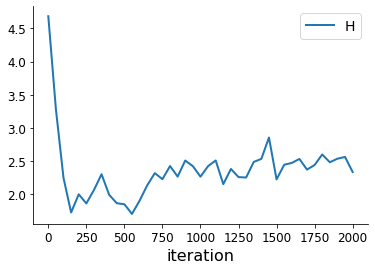

No handles with labels found to put in legend.


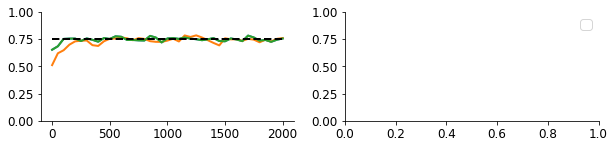

data/epi/SC_Circuit/9ec2a8a430e51c2043a7e4151f221de1/D4_C3_L2_U50_bnmom=9.90E-01_PA_rs2/f1c76a7af74bf78f96682bd2fc852d21/N100_lr1.00E-03_c0=1.00E+03_gamma2.50E-01_beta4.00E+00


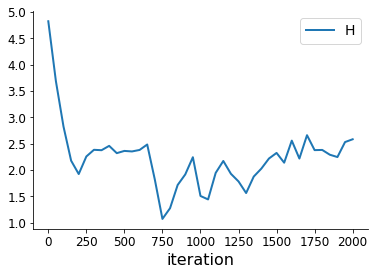

No handles with labels found to put in legend.


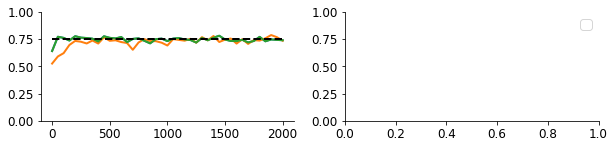

In [6]:
p = 0.75
mu =  [p, 1-p]
epi_df2 = epi_df[(epi_df['p']==p) & (epi_df['c0']==1e3) & (epi_df['mu_len'] == 2)]


paths = sorted(epi_df2['path'].unique())
for i, path in enumerate(paths):
    print(path)
    epi_df2 = epi_df[epi_df['path'] == path]
    epi_df2.plot('iteration', 'H')
    plt.show()
    fig, axs = plt.subplots(1,2,figsize=(10,2))
    Rs = ['R%d' % r for r in range(1,3)]
    axs[0].plot(epi_df2['iteration'], epi_df2['R1'] + mu[0], label=r'$p_P$')
    axs[0].plot(epi_df2['iteration'], 1.-(epi_df2['R2'] + mu[1]), label=r'$p_A$')
    axs[0].plot(epi_df2['iteration'], epi_df2['R1'] + mu[0], label=r'$p_P$')
    axs[0].plot([0, epi_df2['iteration'].max()], [mu[0], mu[0]], 'k--')
    axs[0].set_ylim([0,1])
    #axs[1].plot(epi_df2['iteration'], epi_df2['R3'], label=r'var $p_P$')
    #axs[1].plot(epi_df2['iteration'], epi_df2['R4'], label=r'var $p_A$')
    #axs[1].plot([epi_df2['iteration'].min(), epi_df2['iteration'].max()], [mu_std**2, mu_std**2], 'k--')
    plt.legend()
    plt.show()

In [28]:
best_k = 0
mu = np.array([p, 1.-p])

epi_df2 = epi_df[epi_df['path'] == paths[0]]
df_row = epi_df2.iloc[0]
init = df_row['init']
init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
nf = model._df_row_to_nf(df_row)
aug_lag_hps = model._df_row_to_al_hps(df_row)

dist = model._get_epi_dist(best_k, init_params, nf, mu, aug_lag_hps)
print('dist', dist)

dist <epi.models.Distribution object at 0x7f96f74c2358>


Text(0, 0.5, '$p_A$')

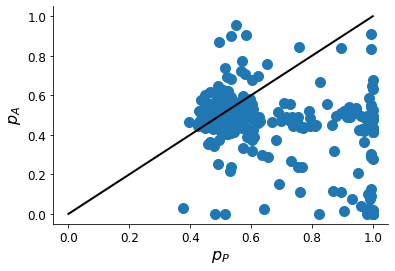

In [29]:
z = dist(500)
"""M = 500
z = np.zeros((M, model.D), dtype=np.float32)
for j in range(model.D):
    z[:,j] = np.random.uniform(model.parameters[j].lb, model.parameters[j].ub, (M,))"""
T_x = model.eps(z).numpy()
plt.scatter(T_x[:,0], 1-T_x[:,1])
plt.plot([0,1], [0,1], 'k-')
plt.xlabel(r'$p_P$')
plt.ylabel(r'$p_A$')

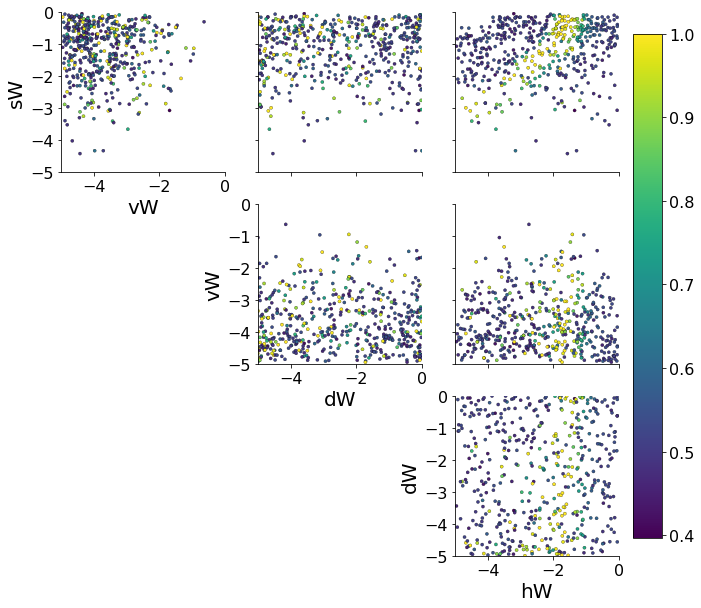

In [27]:
_lb = np.array([p.lb[0] for p in model.parameters])
_ub = np.array([p.ub[0] for p in model.parameters])
z_labels = [p.name for p in model.parameters]
fig = pairplot(z, np.arange(4), z_labels,
               fontsize=20, figsize=(10,10),
               lb=_lb, ub=_ub, c = T_x[:,0])

(500, 4)


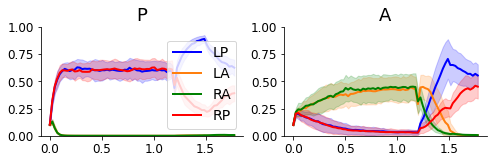

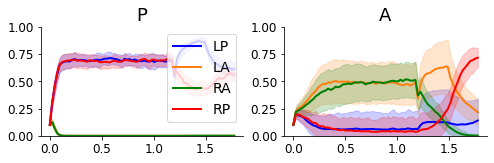

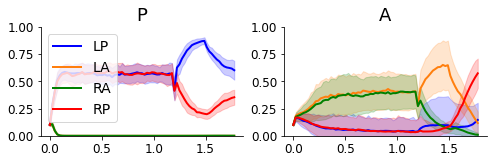

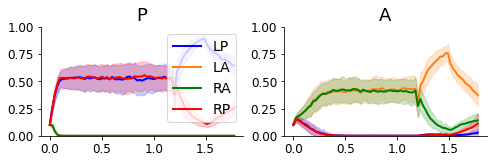

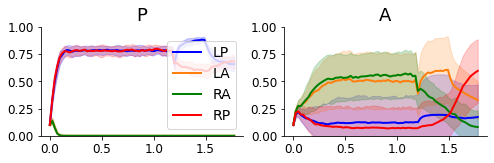

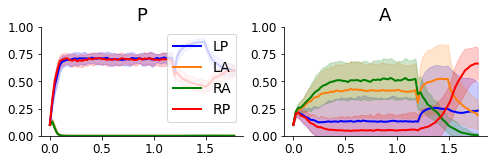

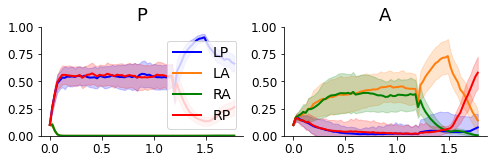

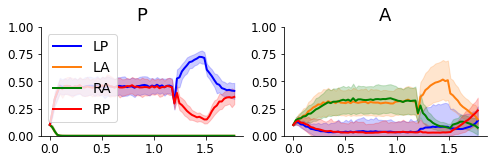

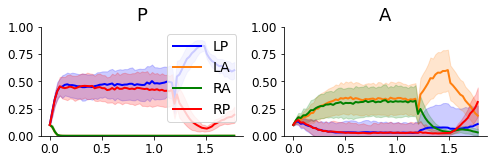

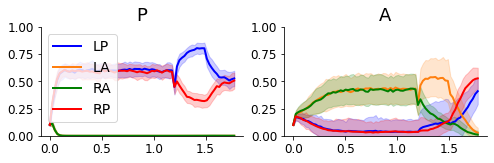

In [24]:
print(z.shape)
u_t, v_t = SC_sim_wrap(z)

neuron_labels = ['LP', 'LA', 'RA', 'RP']
colors = ['b', 'tab:orange', 'g', 'r']
C_titles = ['P', 'A']
for m in range(10):
    fig, axs = plt.subplots(1,2,figsize=(8, 2))
    for c in range(2):
        for i in range(4):
            mean_v = np.mean(v_t[:,m,c,i,:], axis=1)
            std_v = np.std(v_t[:,m,c,i,:], axis=1)
            axs[c].fill_between(t, mean_v - std_v, mean_v + std_v, color=colors[i], alpha=0.2)
            axs[c].plot(t, mean_v, label=neuron_labels[i], c=colors[i])
            axs[c].set_title(C_titles[c])
            axs[c].set_ylim([0,1])
    axs[0].legend()
    plt.show()